# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

# [作業重點]
- 調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~ In[8], Out[5]~ Out[8])
- 調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~ In[11], Out[9]~ Out[11])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# !wget http://ai100.cupoy.com/file-download/part02/titanic_test.csv
# !wget http://ai100.cupoy.com/file-download/part02/titanic_train.csv

data_path = './'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId'] , axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


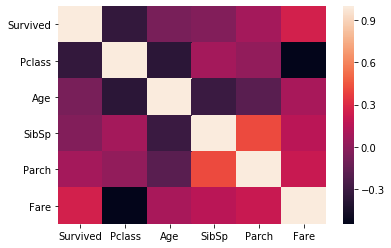

In [2]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr)
plt.show()

In [3]:
# 記得刪除 Survived
df = df.drop(['Survived'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?

In [4]:
# 原始特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression(solver='lbfgs')
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7004864906462793

In [5]:
# 篩選相關係數1
high_list1 = list(corr[(corr['Pclass']>0.1) | (corr['Pclass']<-0.1)].index)
high_list1.pop(0)
print(high_list1)

['Pclass', 'Age', 'Fare']


In [6]:
# 特徵1 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list1])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6859174114924282

In [7]:
# 篩選相關係數2
high_list2 = list(corr[(corr['Age']>0.1) | (corr['Age']<-0.1)].index)
high_list2.pop(0)
print(high_list2)

['Age', 'SibSp', 'Parch']


In [8]:
# 特徵2 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list2])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6105531375242174

# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?

In [9]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.001)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.39684291, -0.25338753, -0.19144856,  0.28161304,  0.28188094])

In [10]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0.1) | (L1_Reg.coef_<-0.1))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [11]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7004864906462793